In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

## Preprocessing

In [16]:
df = pd.read_csv('dataset\wine.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   object 
dtypes: float64(11), object(1)
memory usage: 150.0+ KB


<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\balko\AppData\Local\Temp\ipykernel_12260\3075757770.py:1: SyntaxWarning: invalid escape sequence '\w'
  df = pd.read_csv('dataset\wine.csv')


In [17]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


<Axes: xlabel='quality', ylabel='Count'>

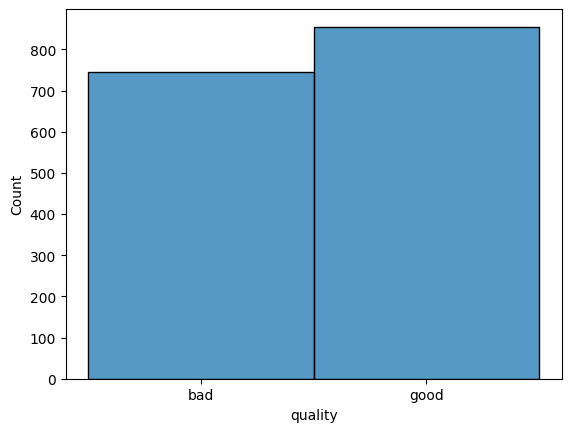

In [18]:
sns.histplot(df, x="quality")

In [19]:
df['quality'] = df['quality'].map({"bad":0,"good":1})
df['quality'].value_counts(normalize=True)

quality
1    0.534709
0    0.465291
Name: proportion, dtype: float64

In [20]:
X = torch.from_numpy(df.drop('quality', axis=1).to_numpy()).to(torch.float32)
y = torch.from_numpy(df['quality'].to_numpy()).to(torch.float32)
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=4)

In [21]:
print(f"Train: {X_train.shape}, valid: {X_valid.shape[0]}")

Train: torch.Size([1279, 11]), valid: 320


In [22]:
y_train

tensor([0., 1., 0.,  ..., 0., 0., 1.])

In [23]:
BATCH_SIZE=X_train.shape[0]

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [40]:
class MyModel(torch.nn.Module):

    def __init__(self, input_size, output_size, hidden_layers, activations):
        super(MyModel, self).__init__()
        self.layers = []
        for i in range(len(hidden_layers)):
            if i == 0:
                self.layers.append(torch.nn.Linear(input_size, hidden_layers[i]))
            else:
                self.layers.append(torch.nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.layers.append(activations[i])

        self.layers.append(torch.nn.Linear(hidden_layers[-1], output_size))
        self.layers.append(torch.nn.Sigmoid())
        self.model = torch.nn.Sequential(*self.layers)
    def forward(self, x):
        x = self.model(x)
        return x.squeeze()

mymodel = MyModel(X_train.shape[1],1,[64,32], [torch.nn.ReLU(), torch.nn.ReLU()])

In [41]:
print(mymodel)

MyModel(
  (model): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [42]:
print('\n\nLinear Layer 2 params:')
for param in mymodel.layers[0].parameters():
    print(param)



Linear Layer 2 params:
Parameter containing:
tensor([[-0.0468, -0.2929, -0.0189, -0.0818,  0.0288,  0.2531, -0.2481,  0.0901,
         -0.0150,  0.2457,  0.2546],
        [ 0.0540,  0.2363,  0.0787,  0.1815,  0.0608,  0.1973,  0.1304, -0.2241,
          0.1886,  0.0903, -0.2419],
        [-0.1359, -0.2902, -0.0297, -0.0238,  0.1030, -0.0758,  0.0397,  0.0464,
         -0.2548, -0.2975,  0.2847],
        [ 0.0239,  0.2020, -0.2599, -0.2370, -0.0147,  0.2004, -0.2502,  0.0043,
         -0.0941, -0.1638,  0.2756],
        [ 0.2607, -0.2651,  0.0011,  0.1761, -0.1104,  0.2713, -0.1544,  0.2429,
          0.1484, -0.1944,  0.2590],
        [-0.1751, -0.2364,  0.0532,  0.2377, -0.0132, -0.2886, -0.0645, -0.0226,
         -0.1139, -0.0123,  0.0233],
        [ 0.0486, -0.2817,  0.1070,  0.1842,  0.2965,  0.2499,  0.1090, -0.0018,
         -0.0614,  0.2146,  0.2008],
        [ 0.3014, -0.0490,  0.0064, -0.2612, -0.1755, -0.1327,  0.0794, -0.2591,
          0.1906,  0.0215,  0.1840],
        [

In PyTorch, the nn.Linear module's weights are initialized by default using a method "He initialization.

In [43]:
NUM_EPOCH = 1001

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(mymodel.parameters(), lr=0.1)

train_loss_list = []
valid_loss_list = []
accuracy_list = []

min_valid_loss = np.inf

for epoch in range(NUM_EPOCH):
    train_loss = 0.0
    mymodel.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        pred = mymodel(inputs)

        loss = loss_fn(pred,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_list.append(train_loss/len(train_loader))

    mymodel.eval()
    valid_loss, correct = 0, 0
    size = len(valid_loader.dataset)
    with torch.no_grad():
        for inputs, labels in valid_loader:
            pred = mymodel(inputs)
            loss = loss_fn(pred,labels)
            valid_loss += loss.item()
            binary_pred = (pred >= 0.5).float()
            correct += (binary_pred==labels).sum().item()
        correct /= size
        valid_loss/=len(valid_loader)
        accuracy_list.append(correct)
        valid_loss_list.append(valid_loss)


    if epoch % 100 == 0:
        print(f"Epoch {epoch}: train_loss = {train_loss_list[epoch]}, valid_loss= {valid_loss_list[epoch]}, accuracy= {correct*100}")

   
    


Epoch 0: train_loss = 0.7073542475700378, valid_loss= 1.648095726966858, accuracy= 49.6875
Epoch 100: train_loss = 0.6354469656944275, valid_loss= 0.6551097631454468, accuracy= 63.125
Epoch 200: train_loss = 0.6295725703239441, valid_loss= 0.650008499622345, accuracy= 63.4375
Epoch 300: train_loss = 0.6278838515281677, valid_loss= 0.6488434076309204, accuracy= 63.4375
Epoch 400: train_loss = 0.6254889369010925, valid_loss= 0.6481658220291138, accuracy= 62.81250000000001
Epoch 500: train_loss = 0.6303005814552307, valid_loss= 0.6457942724227905, accuracy= 63.125
Epoch 600: train_loss = 0.6148650050163269, valid_loss= 0.640773594379425, accuracy= 64.0625
Epoch 700: train_loss = 0.6158975958824158, valid_loss= 0.6581809520721436, accuracy= 62.5
Epoch 800: train_loss = 0.6140666604042053, valid_loss= 0.6420590877532959, accuracy= 63.4375
Epoch 900: train_loss = 0.6138697862625122, valid_loss= 0.6304930448532104, accuracy= 64.0625
Epoch 1000: train_loss = 0.6112934350967407, valid_loss= 0.6

<Axes: >

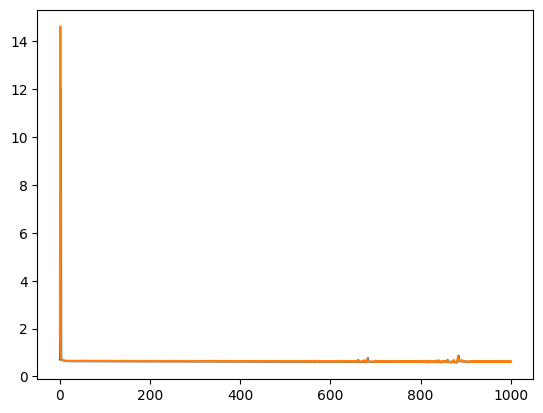

In [44]:
sns.lineplot(train_loss_list)
sns.lineplot(valid_loss_list)

Lets try to improve model 

In [47]:
class MyModel2(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, activations, dropout_rate):
        super(MyModel2, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(torch.nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(torch.nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.LayerNorm(hidden_sizes[i]))
            layers.append(activations[i])
            layers.append(nn.Dropout(dropout_rate[i]))

        # Add the output layer
        layers.append(torch.nn.Linear(hidden_sizes[-1], output_size))
        layers.append(torch.nn.Sigmoid())

        # Create the sequential module
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.model(x)
        return x.squeeze()

hidden_sizes = [512, 256, 64]
activations = [nn.SiLU() for _ in range(len(hidden_sizes))]
dropout_rate = [0.5 for _ in range(len(hidden_sizes))]

model2 = MyModel2(11,1,hidden_sizes, activations, dropout_rate)


In [49]:
print(model2)

MyModel2(
  (model): Sequential(
    (0): Linear(in_features=11, out_features=512, bias=True)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): SiLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (6): SiLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=64, bias=True)
    (9): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (10): SiLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [50]:
NUM_EPOCH = 2001

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1, momentum=0.7)

train_loss_list = []
valid_loss_list = []
accuracy_list = []

min_valid_loss = np.inf

for epoch in range(NUM_EPOCH):
    train_loss = 0.0
    model2.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        pred = model2(inputs)

        loss = loss_fn(pred,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_list.append(train_loss/len(train_loader))

    model2.eval()
    valid_loss, correct = 0, 0
    size = len(valid_loader.dataset)
    with torch.no_grad():
        for inputs, labels in valid_loader:
            pred = model2(inputs)
            loss = loss_fn(pred,labels)
            valid_loss += loss.item()
            binary_pred = (pred >= 0.5).float()
            correct += (binary_pred==labels).sum().item()

        correct /= size
        valid_loss/=len(valid_loader)

        accuracy_list.append(correct)
        valid_loss_list.append(valid_loss)

        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            best_model = model2
            torch.save(model2, 'model/best-model.pt')
            torch.save(model2.state_dict(), 'model/best-model-parameters.pt')
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: train_loss = {train_loss_list[epoch]}, valid_loss= {valid_loss_list[epoch]}, accuracy= {correct*100}")



Epoch 0: train_loss = 0.7244287729263306, valid_loss= 0.7297075986862183, accuracy= 50.31250000000001
Epoch 100: train_loss = 0.6578783988952637, valid_loss= 0.6496275663375854, accuracy= 63.125
Epoch 200: train_loss = 0.6496586203575134, valid_loss= 0.6467707753181458, accuracy= 63.125
Epoch 300: train_loss = 0.6481963992118835, valid_loss= 0.6451225280761719, accuracy= 63.4375
Epoch 400: train_loss = 0.6409396529197693, valid_loss= 0.6452909111976624, accuracy= 63.4375
Epoch 500: train_loss = 0.643517017364502, valid_loss= 0.6427110433578491, accuracy= 63.4375
Epoch 600: train_loss = 0.6405513286590576, valid_loss= 0.6407368779182434, accuracy= 63.74999999999999
Epoch 700: train_loss = 0.6391772031784058, valid_loss= 0.6386175751686096, accuracy= 63.125
Epoch 800: train_loss = 0.6317360997200012, valid_loss= 0.6346420049667358, accuracy= 63.125
Epoch 900: train_loss = 0.6304225921630859, valid_loss= 0.6239259839057922, accuracy= 65.0
Epoch 1000: train_loss = 0.6270045042037964, valid

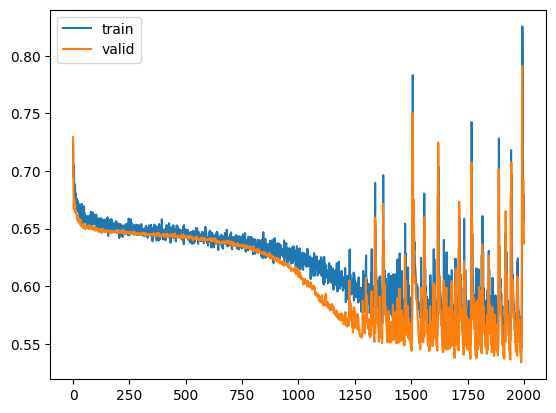

In [51]:
sns.lineplot(train_loss_list, label="train")
sns.lineplot(valid_loss_list, label="valid")
plt.legend()

In [53]:
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score

best_model = MyModel2(11,1,hidden_sizes, activations, dropout_rate)
best_model.load_state_dict(torch.load('model/best-model-parameters.pt'))
best_model.eval()
with torch.no_grad():
    pred = best_model(X_valid)

# Convert pred to a float tensor
pred = (pred > 0.5).to(torch.float)

# Calculate accuracy
accuracy = BinaryAccuracy()
f1_score = BinaryF1Score()
print(f"Accuracy: {accuracy(pred, y_valid)}, f1_score: {f1_score(pred, y_valid)}")

Accuracy: 0.737500011920929, f1_score: 0.7324841022491455


**Conclusions**: My model achieved an accuracy of 73,75%, wich is not so good. Maybe we need more data or more comlexity model. Compared to ml algorithms for this dataset, my model gives almost the same results